# Import required libraries

In [1]:
import torch
import torchvision
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from math import ceil
from math import sqrt
from skimage.transform import resize
from skimage import io
from tqdm import tqdm
import numpy as np
from skimage.util import img_as_ubyte

#Device configuration
device=torch.device('cpu')
if torch.cuda.is_available():
    device=torch.device('cuda')

# Specify the dataset path (Caltech-UCSD Birds 200)

In [2]:
data_path = r'D:\Datasets\CUB_200_2011'
images_dir = os.path.join(data_path,'images')

# Visualize Dataset Balance

In [3]:
freqs = []
labels = []

dirs = os.listdir(images_dir)

for directory in dirs:
    dir_pth = os.path.join(images_dir, directory)
    labels.append(directory)
    freqs.append(len(os.listdir(dir_pth)))

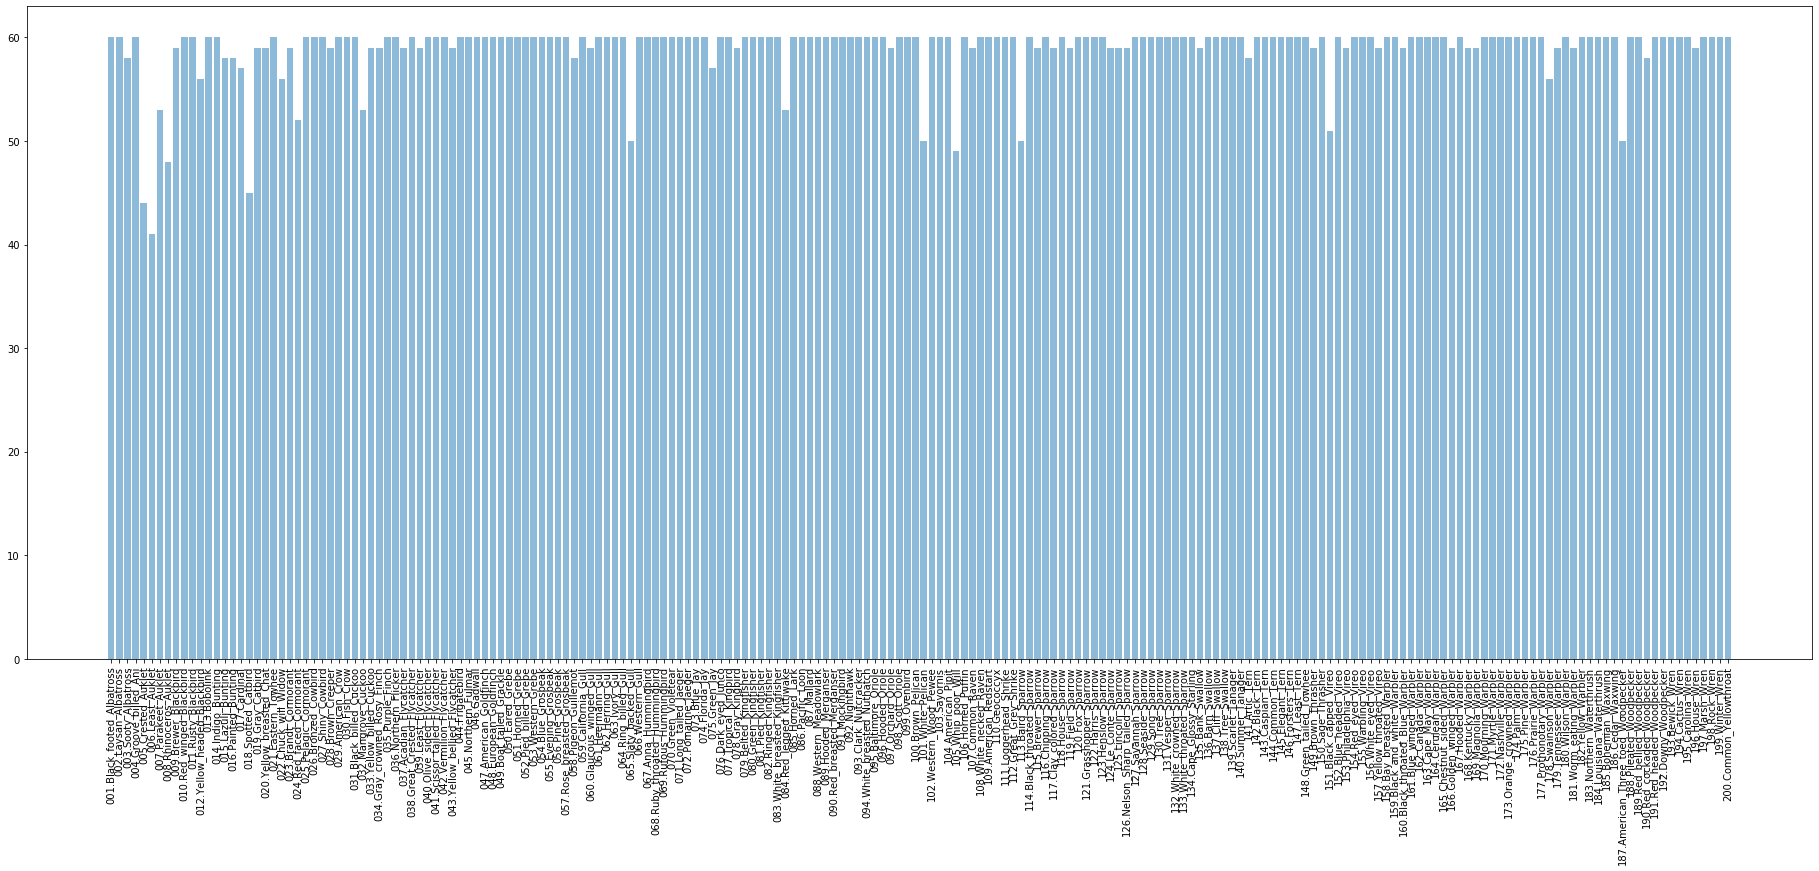

In [4]:
plt.figure(figsize=(32, 12))
y_pos = np.arange(len(labels))
plt.bar(y_pos, freqs, align='center', alpha=0.5)
plt.xticks(y_pos, labels, rotation=90)
plt.show();

In [5]:
max_freq=np.max(freqs)
max_freq

60

# Resize on Disk to avoid resizing on each epoch and selecting the specific no of types of birds (here taken 20 each with 60 images)

In [6]:
#Global variables
mini_dir = 'minidata-birds'
#Change to true
bool_minify = True  

#Execute this code only once
if bool_minify:

    #Check directory exists
    if not os.path.exists(mini_dir):
        #Create mini-birds dataset directory
        os.mkdir(mini_dir)
    #First 20 directories (labels)
    directories = os.listdir(images_dir)
    #Loop sentinent
    loop_counter = 0
    
    #Loop directories
    for i, directory in enumerate(directories):
        #Stop after 20
        if loop_counter == 20:
            break
        #Bookmark original directory
        source_dir = os.path.join(images_dir, directory)
        #Check frequency
        if max_freq > len(os.listdir(source_dir)):
            continue
        else:
            loop_counter += 1
        #Bookmark destination directory
        target_dir = os.path.join(mini_dir, directory)
        #Create target directory
        if not os.path.exists(target_dir):
            os.mkdir(target_dir)
        #List files inside category
        images_files = os.listdir(source_dir)
        #Init progress bar
        pbar = tqdm(total=len(images_files))
        #Loop images inside each directory
        for image_file in images_files:
            #Read image
            image = io.imread(os.path.join(source_dir, image_file))
            #Resize image and save
            new_image = resize(image, (64, 64), anti_aliasing=True)
            #Ruppress image type warning
            new_image = img_as_ubyte(new_image)
            #Save images
            io.imsave(os.path.join(target_dir, image_file), new_image)
            #Update progress bar
            pbar.update(1)
        #End progress bar
        pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 54.83it/s]


# Data Preprocessing

In [7]:
class SquashTransform:
    def __call__(self, inputs):
        return 2 * inputs - 1

data_train = torchvision.datasets.ImageFolder(
    mini_dir,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        SquashTransform()
    ])
)

In [8]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

num_steps=ceil(1200/batch_size)
num_steps

10

# Visualize Preprocessed Dataset

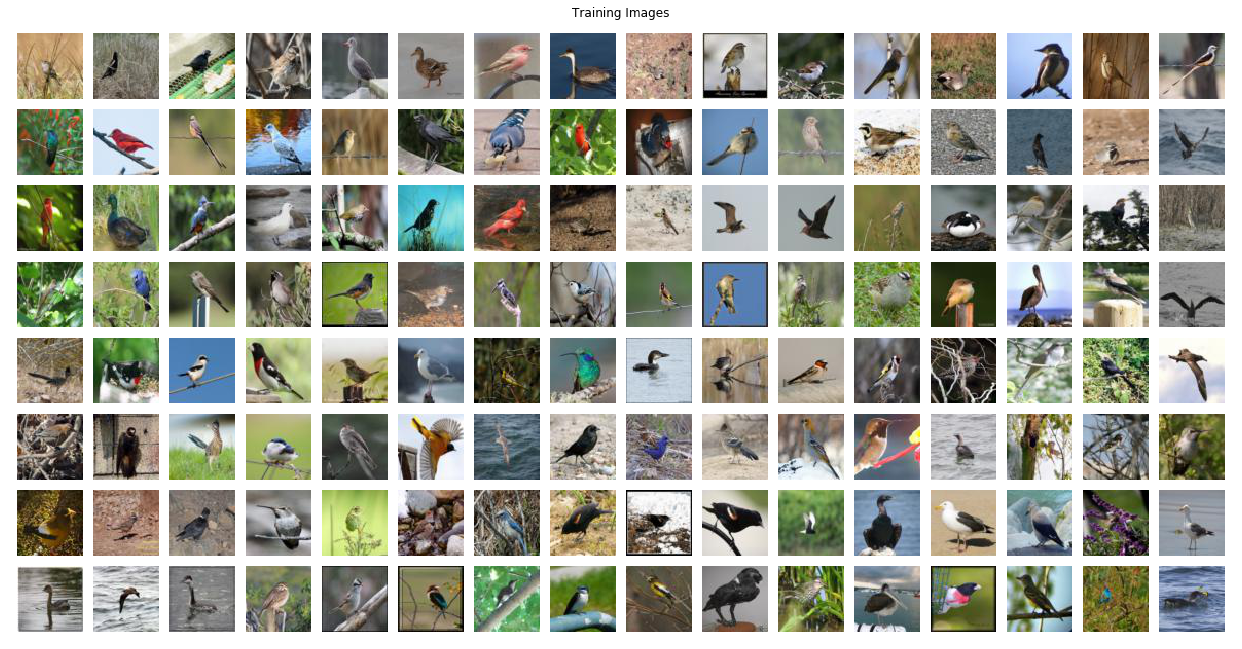

In [9]:
#Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(22, 12))
plt.axis("off")
plt.title("Training Images")

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device),
            padding=10,
            normalize=True,
            pad_value=1,
            nrow=int(3 * sqrt(batch_size ) / 2)
        ).cpu(),
        (1,2,0)
    )
);

# Global Dimensions

In [10]:
#Number of channels in the training images.
nc = 3
#Size of z latent vector (size of generator input)
nz = 100
#Size of feature maps in generator
ngf = 64
#Size of feature maps in discriminator
ndf = 64

# Generator Design

In [11]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = torch.nn.Sequential(
            #Input is nz
            torch.nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=ngf* 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False),
            torch.nn.BatchNorm2d(num_features=ngf * 8),
            torch.nn.ReLU(inplace=True),

            #(ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 8,
                out_channels=ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.BatchNorm2d(num_features=ngf * 4),
            torch.nn.ReLU(inplace=True),

            #(ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 4,
                out_channels=ngf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.BatchNorm2d(num_features=ngf * 2),
            torch.nn.ReLU(inplace=True),

            #(ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 2,
                out_channels=ngf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.BatchNorm2d(num_features=ngf),
            torch.nn.ReLU(inplace=True),

            #(ngf) x 32 x 32
            torch.nn.ConvTranspose2d(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.Tanh()
            #(nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Design

In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = torch.nn.Sequential(
            #Input is (nc) x 64 x 64
            torch.nn.Conv2d(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #(ndf) x 32 x 32
            torch.nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.BatchNorm2d(num_features=ndf * 2),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #(ndf*2) x 16 x 16
            torch.nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.BatchNorm2d(num_features=ndf * 4),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #(ndf*4) x 8 x 8
            torch.nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False),
            torch.nn.BatchNorm2d(num_features=ndf * 8),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #(ndf*8) x 4 x 4
            torch.nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

# Weight Initialization

In [13]:
#Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)
        
# Initialize Models
netD = Discriminator().to(device)
netG = Generator().to(device)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Optimizer

In [14]:
#Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [15]:
criterion = torch.nn.BCELoss()
fixed_noise = torch.randn(25, nz, 1, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

# Train Discriminator

In [16]:
def trainD(images):
    real_images = images.to(device)
    fake_images = netG(torch.randn(batch_size, nz, 1, 1).to(device))
    optimizerD.zero_grad()
    real_outputs = netD(real_images)
    fake_outputs = netD(fake_images)
    d_x = criterion(real_outputs, real_labels)
    d_g_z = criterion(fake_outputs, fake_labels)
    d_x.backward()
    d_g_z.backward()
    optimizerD.step()
    loss = d_x + d_g_z
    return loss

# Train Generator

In [17]:
def trainG():
    z = torch.randn(batch_size, nz, 1, 1).to(device)
    netG.zero_grad()
    outputs = netD(netG(z))
    loss = criterion(outputs, real_labels)
    loss.backward()
    optimizerG.step()
    return loss

# Load Checkpoint

In [21]:
if os.path.exists('netG.pytorch'):
    netG.load_state_dict(torch.load('netG.pytorch'))

if os.path.exists('netD.pytorch'):
    netD.load_state_dict(torch.load('netD.pytorch'))

if os.path.exists('optG.pytorch'):
    optimizerG.load_state_dict(torch.load('optG.pytorch'))

if os.path.exists('optD.pytorch'):
    optimizerD.load_state_dict(torch.load('optD.pytorch'))

# Train the Network

In [22]:
for epoch in range(2000):
    d_loss = 0
    g_loss = 0
    for i, (images, _) in enumerate(train_loader):
        if i == num_steps:
            break
        for k in range(4):
             d_loss += trainD(images)
        g_loss = trainG()
    #Log & save checkpoint only every X epochs
    if epoch % 1 == 0:
        #G & D Loss
        print("E:{}, G Loss:{}, D Loss:{}".format(epoch,g_loss / num_steps, d_loss / num_steps / 4))
        generated = netG(fixed_noise).detach().cpu().view(-1, 3, 64, 64)
        grid = torchvision.utils.make_grid(generated, nrow=5, padding=10, pad_value=1, normalize=True)
        # Save checkpoint
        torch.save(netG.state_dict(), 'netG.pytorch')
        torch.save(netD.state_dict(), 'netD.pytorch')
        torch.save(optimizerG.state_dict(), 'optG.pytorch')
        torch.save(optimizerD.state_dict(), 'optD.pytorch')

E:0, G Loss:0.5432372093200684, D Loss:0.17924365401268005
E:1, G Loss:0.7283649444580078, D Loss:0.08380726724863052
E:2, G Loss:0.6705692410469055, D Loss:0.13054586946964264
E:3, G Loss:0.9897715449333191, D Loss:0.10356546938419342
E:4, G Loss:0.6612586975097656, D Loss:0.17746613919734955
E:5, G Loss:0.7997083067893982, D Loss:0.05756548047065735
E:6, G Loss:0.49339428544044495, D Loss:0.2465137094259262
E:7, G Loss:0.6795668601989746, D Loss:0.07969757914543152
E:8, G Loss:0.6109851002693176, D Loss:0.08167188614606857
E:9, G Loss:0.6787797808647156, D Loss:0.12237135320901871
E:10, G Loss:0.5999865531921387, D Loss:0.3480057418346405
E:11, G Loss:0.7231292724609375, D Loss:0.30981045961380005
E:12, G Loss:0.518109917640686, D Loss:0.5340455174446106
E:13, G Loss:0.5702094435691833, D Loss:0.18515382707118988
E:14, G Loss:0.8511616587638855, D Loss:0.177482008934021
E:15, G Loss:0.7046023607254028, D Loss:0.07379069179296494
E:16, G Loss:0.7140099406242371, D Loss:0.2124323844909

E:137, G Loss:0.6025727391242981, D Loss:0.02022152952849865
E:138, G Loss:0.7871286869049072, D Loss:0.04429842159152031
E:139, G Loss:0.6721746325492859, D Loss:0.03340817615389824
E:140, G Loss:0.5462414622306824, D Loss:0.04254106804728508
E:141, G Loss:0.6900065541267395, D Loss:0.03201672434806824
E:142, G Loss:0.6384034752845764, D Loss:0.029863154515624046
E:143, G Loss:0.7531334161758423, D Loss:0.04068383201956749
E:144, G Loss:0.7545050978660583, D Loss:0.042115457355976105
E:145, G Loss:0.8059973120689392, D Loss:0.03402968496084213
E:146, G Loss:0.6453292369842529, D Loss:0.0318591371178627
E:147, G Loss:0.7136538624763489, D Loss:0.030845148488879204
E:148, G Loss:0.7985267043113708, D Loss:0.027811406180262566
E:149, G Loss:0.6730322241783142, D Loss:0.028607472777366638
E:150, G Loss:1.6016933917999268, D Loss:1.0733962059020996
E:151, G Loss:0.8976728320121765, D Loss:0.6830942630767822
E:152, G Loss:0.5975845456123352, D Loss:0.09933353215456009
E:153, G Loss:0.690933

E:272, G Loss:0.6613717675209045, D Loss:0.08088307082653046
E:273, G Loss:0.6904950141906738, D Loss:0.0544537678360939
E:274, G Loss:0.6772630214691162, D Loss:0.23031163215637207
E:275, G Loss:0.7465939521789551, D Loss:0.3231334984302521
E:276, G Loss:0.663054883480072, D Loss:0.058821406215429306
E:277, G Loss:0.5788235068321228, D Loss:0.04414265602827072
E:278, G Loss:0.6657967567443848, D Loss:0.040470194071531296
E:279, G Loss:0.6935643553733826, D Loss:0.04480336606502533
E:280, G Loss:0.6121793389320374, D Loss:0.040082260966300964
E:281, G Loss:0.5289953351020813, D Loss:0.03168584033846855
E:282, G Loss:0.6986257433891296, D Loss:0.03084639273583889
E:283, G Loss:0.6906554102897644, D Loss:0.03028460405766964
E:284, G Loss:0.6285744905471802, D Loss:0.03505824878811836
E:285, G Loss:0.6417864561080933, D Loss:0.030246883630752563
E:286, G Loss:0.688986599445343, D Loss:0.032330404967069626
E:287, G Loss:0.7776345014572144, D Loss:0.031982067972421646
E:288, G Loss:0.699535

E:407, G Loss:0.6128495335578918, D Loss:0.037584587931632996
E:408, G Loss:0.7010630369186401, D Loss:0.04626668244600296
E:409, G Loss:0.653695285320282, D Loss:0.036418259143829346
E:410, G Loss:0.6606301665306091, D Loss:0.03154463693499565
E:411, G Loss:0.5970519185066223, D Loss:0.028418248519301414
E:412, G Loss:0.6514459848403931, D Loss:0.03325680270791054
E:413, G Loss:0.646341860294342, D Loss:0.028789782896637917
E:414, G Loss:0.6664377450942993, D Loss:0.03611348196864128
E:415, G Loss:0.6365202069282532, D Loss:0.027711650356650352
E:416, G Loss:0.7191578149795532, D Loss:0.03109869919717312
E:417, G Loss:0.6518126130104065, D Loss:0.028135454282164574
E:418, G Loss:0.5349594950675964, D Loss:1.436096429824829
E:419, G Loss:0.5445626378059387, D Loss:0.3324647843837738
E:420, G Loss:0.6763541102409363, D Loss:0.12340853363275528
E:421, G Loss:0.5489997267723083, D Loss:0.07371055334806442
E:422, G Loss:0.7330042719841003, D Loss:0.06121370941400528
E:423, G Loss:0.6079918

E:542, G Loss:0.7272195219993591, D Loss:0.01683907024562359
E:543, G Loss:0.7584596872329712, D Loss:0.025313938036561012
E:544, G Loss:0.6822940111160278, D Loss:0.012792644090950489
E:545, G Loss:0.7066373229026794, D Loss:0.018507469445466995
E:546, G Loss:0.7388047575950623, D Loss:0.01586303673684597
E:547, G Loss:0.6815283298492432, D Loss:1.459987998008728
E:548, G Loss:0.8158027529716492, D Loss:0.5552567839622498
E:549, G Loss:0.6975346207618713, D Loss:0.21466372907161713
E:550, G Loss:0.7123940587043762, D Loss:0.11889944225549698
E:551, G Loss:0.6744896769523621, D Loss:0.2305268794298172
E:552, G Loss:0.6696294546127319, D Loss:0.07392028719186783
E:553, G Loss:0.7017879486083984, D Loss:0.05943349748849869
E:554, G Loss:0.6155088543891907, D Loss:0.05214586853981018
E:555, G Loss:0.589960515499115, D Loss:0.04504141956567764
E:556, G Loss:0.6458504796028137, D Loss:0.03382134810090065
E:557, G Loss:0.5981062054634094, D Loss:0.030926739796996117
E:558, G Loss:0.725230991

E:677, G Loss:0.7300301194190979, D Loss:0.03859725221991539
E:678, G Loss:0.7558286786079407, D Loss:0.025097105652093887
E:679, G Loss:0.6575525403022766, D Loss:0.02479596994817257
E:680, G Loss:0.6928471922874451, D Loss:0.021957747638225555
E:681, G Loss:0.6561359763145447, D Loss:0.017752988263964653
E:682, G Loss:0.612596333026886, D Loss:0.019338073208928108
E:683, G Loss:0.7504810690879822, D Loss:0.014728734269738197
E:684, G Loss:0.7034451365470886, D Loss:0.023382140323519707
E:685, G Loss:0.6042226552963257, D Loss:0.019666586071252823
E:686, G Loss:0.7955037355422974, D Loss:0.018932515755295753
E:687, G Loss:0.7284124493598938, D Loss:0.013538971543312073
E:688, G Loss:0.7952668070793152, D Loss:0.01456695981323719
E:689, G Loss:0.7132335901260376, D Loss:0.012256469577550888
E:690, G Loss:0.7978305220603943, D Loss:0.012614852748811245
E:691, G Loss:0.746772050857544, D Loss:0.011283832602202892
E:692, G Loss:0.7621554732322693, D Loss:0.012194028124213219
E:693, G Loss

E:811, G Loss:0.7195985913276672, D Loss:0.03975406289100647
E:812, G Loss:0.7547087669372559, D Loss:0.033125486224889755
E:813, G Loss:0.7389616966247559, D Loss:0.0319017618894577
E:814, G Loss:0.6702137589454651, D Loss:0.0223592109978199
E:815, G Loss:0.746393620967865, D Loss:0.02108004316687584
E:816, G Loss:0.6504055261611938, D Loss:0.020084528252482414
E:817, G Loss:0.6989194750785828, D Loss:0.018253499642014503
E:818, G Loss:0.7664893269538879, D Loss:0.017600061371922493
E:819, G Loss:0.7034565210342407, D Loss:0.016255749389529228
E:820, G Loss:0.6619641780853271, D Loss:0.014150922186672688
E:821, G Loss:0.719654381275177, D Loss:0.016305716708302498
E:822, G Loss:0.6915729641914368, D Loss:0.012745998799800873
E:823, G Loss:0.6952013969421387, D Loss:0.012947628274559975
E:824, G Loss:0.8278272747993469, D Loss:0.01274819578975439
E:825, G Loss:0.7075967788696289, D Loss:0.013687282800674438
E:826, G Loss:0.7326034903526306, D Loss:0.012374216690659523
E:827, G Loss:0.8

E:945, G Loss:0.7196601033210754, D Loss:0.012623707763850689
E:946, G Loss:0.770173192024231, D Loss:0.00994933769106865
E:947, G Loss:0.8522447943687439, D Loss:0.014298706315457821
E:948, G Loss:0.872894287109375, D Loss:0.011567431502044201
E:949, G Loss:0.8589826822280884, D Loss:0.008746526204049587
E:950, G Loss:0.690629780292511, D Loss:0.009630834683775902
E:951, G Loss:0.7595751881599426, D Loss:0.01160846184939146
E:952, G Loss:0.7496349215507507, D Loss:0.008092637173831463
E:953, G Loss:0.7668650150299072, D Loss:0.008238441310822964
E:954, G Loss:0.7284714579582214, D Loss:0.008187654428184032
E:955, G Loss:0.8756557703018188, D Loss:0.007910489104688168
E:956, G Loss:0.804818332195282, D Loss:0.00930488295853138
E:957, G Loss:0.7577000260353088, D Loss:0.006394877564162016
E:958, G Loss:0.8114451766014099, D Loss:0.008262635208666325
E:959, G Loss:0.8854702115058899, D Loss:0.00725255161523819
E:960, G Loss:0.8042923212051392, D Loss:0.008095931261777878
E:961, G Loss:0.

E:1077, G Loss:0.7866190671920776, D Loss:0.00929188635200262
E:1078, G Loss:0.8283911943435669, D Loss:0.008461320772767067
E:1079, G Loss:0.8317548632621765, D Loss:0.011844228021800518
E:1080, G Loss:0.7484521269798279, D Loss:0.009059020318090916
E:1081, G Loss:0.8349525332450867, D Loss:0.010559934191405773
E:1082, G Loss:0.7323691248893738, D Loss:0.008656758815050125
E:1083, G Loss:0.7438772320747375, D Loss:0.006952484603971243
E:1084, G Loss:0.8020297288894653, D Loss:0.010002726688981056
E:1085, G Loss:0.7686006426811218, D Loss:0.00847146101295948
E:1086, G Loss:0.8198069930076599, D Loss:0.014172854833304882
E:1087, G Loss:0.873934268951416, D Loss:0.5587098002433777
E:1088, G Loss:0.9148818254470825, D Loss:0.48464903235435486
E:1089, G Loss:0.9623042345046997, D Loss:0.09813075512647629
E:1090, G Loss:0.8132658004760742, D Loss:0.044117268174886703
E:1091, G Loss:0.8052997589111328, D Loss:0.03241192549467087
E:1092, G Loss:0.793035626411438, D Loss:0.023590324446558952
E

E:1209, G Loss:0.8956834673881531, D Loss:0.007736098021268845
E:1210, G Loss:0.8445254564285278, D Loss:0.009707029908895493
E:1211, G Loss:0.8871922492980957, D Loss:0.005951480474323034
E:1212, G Loss:0.8722307085990906, D Loss:0.005800049286335707
E:1213, G Loss:0.8584513664245605, D Loss:0.004884412046521902
E:1214, G Loss:0.7670966386795044, D Loss:0.005357789341360331
E:1215, G Loss:0.8851601481437683, D Loss:0.004596763756126165
E:1216, G Loss:0.88079434633255, D Loss:0.004873089026659727
E:1217, G Loss:0.733798623085022, D Loss:0.004559885710477829
E:1218, G Loss:2.1500720977783203, D Loss:0.04401836544275284
E:1219, G Loss:0.9471351504325867, D Loss:1.064167857170105
E:1220, G Loss:0.8244120478630066, D Loss:0.19462715089321136
E:1221, G Loss:0.7757817506790161, D Loss:0.08388585597276688
E:1222, G Loss:0.8607973456382751, D Loss:0.06499329954385757
E:1223, G Loss:0.8819646835327148, D Loss:0.04321824014186859
E:1224, G Loss:0.8532747626304626, D Loss:0.028379490599036217
E:1

E:1340, G Loss:0.8395674824714661, D Loss:0.0034053733106702566
E:1341, G Loss:0.9044771194458008, D Loss:0.002779122442007065
E:1342, G Loss:0.833308219909668, D Loss:0.0035058078356087208
E:1343, G Loss:0.9316455721855164, D Loss:0.003300132928416133
E:1344, G Loss:0.9276605844497681, D Loss:0.0028437527362257242
E:1345, G Loss:0.9210015535354614, D Loss:0.0030109023209661245
E:1346, G Loss:0.9679655432701111, D Loss:0.0030476958490908146
E:1347, G Loss:0.8797300457954407, D Loss:0.002558802254498005
E:1348, G Loss:0.882354199886322, D Loss:0.003458671271800995
E:1349, G Loss:0.8734779357910156, D Loss:0.0030940005090087652
E:1350, G Loss:0.9303448796272278, D Loss:0.002653483534231782
E:1351, G Loss:0.9606102108955383, D Loss:0.0033675467129796743
E:1352, G Loss:0.8568169474601746, D Loss:0.0025597105268388987
E:1353, G Loss:0.47923633456230164, D Loss:1.7885271310806274
E:1354, G Loss:0.77264004945755, D Loss:0.6477818489074707
E:1355, G Loss:0.7286921739578247, D Loss:0.3589257001

E:1471, G Loss:0.8886396288871765, D Loss:0.017693104222416878
E:1472, G Loss:0.860008716583252, D Loss:0.013987818732857704
E:1473, G Loss:0.9230253100395203, D Loss:0.015489272773265839
E:1474, G Loss:0.8693097233772278, D Loss:0.013663435354828835
E:1475, G Loss:0.7838079333305359, D Loss:0.014953525736927986
E:1476, G Loss:0.8427715301513672, D Loss:0.011030667461454868
E:1477, G Loss:0.975019633769989, D Loss:0.01191047951579094
E:1478, G Loss:0.8560266494750977, D Loss:0.00905981007963419
E:1479, G Loss:0.9437772631645203, D Loss:0.012350927107036114
E:1480, G Loss:0.8896772265434265, D Loss:0.00917618628591299
E:1481, G Loss:0.8698658347129822, D Loss:0.010401838459074497
E:1482, G Loss:0.8670668601989746, D Loss:0.00989394448697567
E:1483, G Loss:0.7969012260437012, D Loss:0.008002866990864277
E:1484, G Loss:0.8269504904747009, D Loss:0.00865016970783472
E:1485, G Loss:0.8197135329246521, D Loss:0.41747698187828064
E:1486, G Loss:0.9748386740684509, D Loss:0.14934559166431427
E

E:1602, G Loss:1.1386370658874512, D Loss:0.1332394778728485
E:1603, G Loss:0.9008764624595642, D Loss:0.06782021373510361
E:1604, G Loss:0.9224168658256531, D Loss:0.036888401955366135
E:1605, G Loss:0.9129132628440857, D Loss:0.016919825226068497
E:1606, G Loss:0.8777141571044922, D Loss:0.019209066405892372
E:1607, G Loss:0.9575281143188477, D Loss:0.013805093243718147
E:1608, G Loss:0.8172414898872375, D Loss:0.015170655213296413
E:1609, G Loss:0.9142395853996277, D Loss:0.011822473257780075
E:1610, G Loss:0.8577465415000916, D Loss:0.008707694709300995
E:1611, G Loss:0.8688036799430847, D Loss:0.00883728638291359
E:1612, G Loss:0.865456759929657, D Loss:0.00978184025734663
E:1613, G Loss:0.8512566685676575, D Loss:0.0069224112667143345
E:1614, G Loss:0.8835861086845398, D Loss:0.007214137353003025
E:1615, G Loss:0.9084284901618958, D Loss:0.0070371851325035095
E:1616, G Loss:0.8643569946289062, D Loss:0.0061993058770895
E:1617, G Loss:0.8642744421958923, D Loss:0.00684584164991974

E:1733, G Loss:0.8630787134170532, D Loss:0.04167773574590683
E:1734, G Loss:0.8824877142906189, D Loss:0.03182241693139076
E:1735, G Loss:0.8476340174674988, D Loss:0.020968791097402573
E:1736, G Loss:0.8802446722984314, D Loss:0.024983923882246017
E:1737, G Loss:0.8594172596931458, D Loss:0.01709519512951374
E:1738, G Loss:0.8160614371299744, D Loss:0.013943909667432308
E:1739, G Loss:0.8942010998725891, D Loss:0.013229249976575375
E:1740, G Loss:0.9460548758506775, D Loss:0.014289948157966137
E:1741, G Loss:0.8630909323692322, D Loss:0.012699051760137081
E:1742, G Loss:0.8118028044700623, D Loss:0.01041173841804266
E:1743, G Loss:0.8901275992393494, D Loss:0.010075504891574383
E:1744, G Loss:0.8815441131591797, D Loss:0.011262083426117897
E:1745, G Loss:0.8310760855674744, D Loss:0.007343193981796503
E:1746, G Loss:0.9023386240005493, D Loss:0.007920329459011555
E:1747, G Loss:0.840122640132904, D Loss:0.007252419833093882
E:1748, G Loss:0.8849492073059082, D Loss:0.0058201630599796

E:1864, G Loss:0.8594666719436646, D Loss:0.003527212655171752
E:1865, G Loss:0.9401626586914062, D Loss:0.005249391309916973
E:1866, G Loss:1.0044445991516113, D Loss:0.003359416965395212
E:1867, G Loss:0.9167293906211853, D Loss:0.0035377952735871077
E:1868, G Loss:1.0363397598266602, D Loss:0.0031411319505423307
E:1869, G Loss:1.0058201551437378, D Loss:0.005762553308159113
E:1870, G Loss:1.0359020233154297, D Loss:0.006142943631857634
E:1871, G Loss:0.9764774441719055, D Loss:0.003221216145902872
E:1872, G Loss:1.0253409147262573, D Loss:0.0034842544700950384
E:1873, G Loss:1.0695785284042358, D Loss:0.004264694172888994
E:1874, G Loss:0.9799579977989197, D Loss:0.0027897616382688284
E:1875, G Loss:0.9110954403877258, D Loss:0.0024573435075581074
E:1876, G Loss:1.0188673734664917, D Loss:0.6664881110191345
E:1877, G Loss:1.0178768634796143, D Loss:0.11381291598081589
E:1878, G Loss:1.284385323524475, D Loss:0.06962580233812332
E:1879, G Loss:0.9343708157539368, D Loss:0.03771610185

E:1995, G Loss:0.9411649703979492, D Loss:0.0036739420611411333
E:1996, G Loss:0.9781000018119812, D Loss:0.0023398285266011953
E:1997, G Loss:0.9388193488121033, D Loss:0.0023473321925848722
E:1998, G Loss:1.0094259977340698, D Loss:0.003303906414657831
E:1999, G Loss:0.956281840801239, D Loss:0.002947844099253416


# Visualize Result

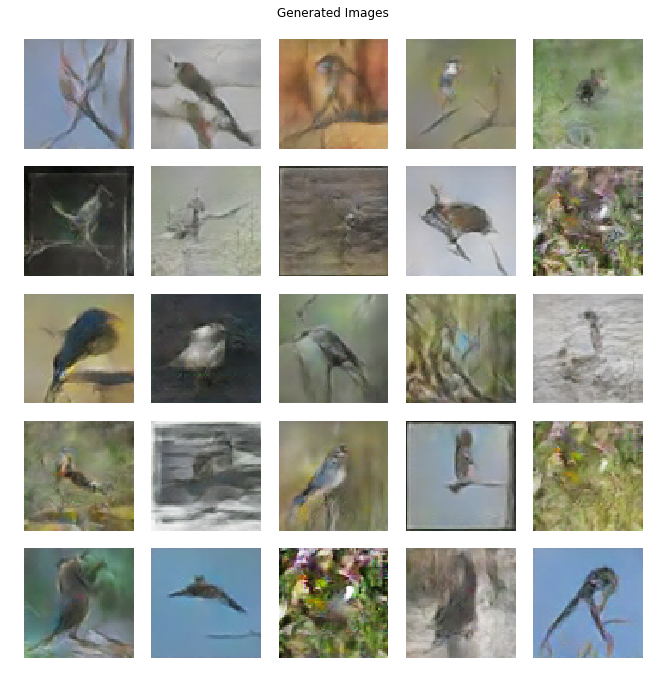

In [23]:
generated = netG(fixed_noise).detach().cpu().view(-1, 3, 64, 64)
grid = torchvision.utils.make_grid(generated, nrow=5, padding=10, pad_value=1, normalize=True)
plt.figure(figsize=(16, 12))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(grid,(1, 2, 0)));